# Домашнее задание к лекции "Статистика. Практика"

## Задание 1

Вернемся к [набору данных о видеоиграх](https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/vgsales.csv).

Ответьте на следующие вопросы:

1) Как критики относятся к спортивным играм?  
2) Критикам нравятся больше игры на PC или на PS4?  
3) Критикам больше нравятся стрелялки или стратегии?  

Для каждого вопроса:
- сформулируйте нулевую и альтернативную гипотезы;
- выберите пороговый уровень статистической значимости;
- опишите полученные результаты статистического теста.

`Сразу отмечу, что пороговый уровень статистической значимости мы во всех тестах для простоты примем равным 0.05`

### Проверим и подготовим данные

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/vgsales.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Посмотрим что вообще подгрузили
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [4]:
#Одна из интересующих колонок в классе object
df.User_Count

0        322.0
1          NaN
2        709.0
3        192.0
4          NaN
         ...  
16714      NaN
16715      NaN
16716      NaN
16717      NaN
16718      NaN
Name: User_Count, Length: 16719, dtype: float64

In [5]:
# Явно потому что тут есть tbd. Удалим это дело и конвертируем
df.drop(df[(df['User_Score'] == 'tbd')].index, inplace=True)
df['User_Score'] = pd.to_numeric(df['User_Score'])

### 1. Как критики относятся к спортивным играм?

Нулевая гипотеза заключается в том, что критики относятся к играм так же, как обычные юзеры </br>
Альтернативная - относятся к ним по иному в том или ином виде </br></br>

In [6]:
df_nona = df.dropna()[['Name','Critic_Score','User_Score']].reset_index(drop=True)
df_nona['User_Score'] = df_nona['User_Score'] * 10
df_nona = df_nona.melt('Name', var_name='data_type', value_name='score').copy()

In [7]:
import seaborn as sns
sns.set_theme()

<AxesSubplot: xlabel='score', ylabel='Count'>

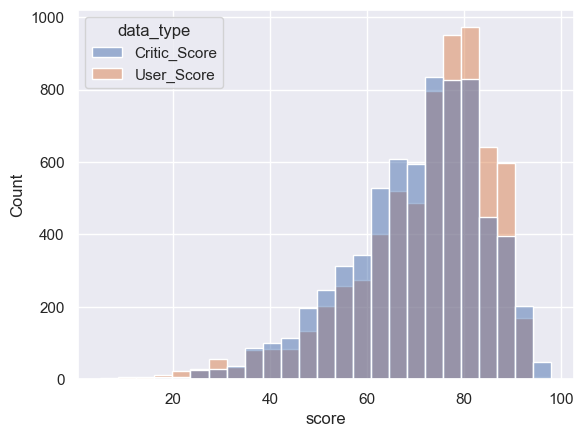

In [8]:
sns.histplot(data=df_nona, x='score', hue='data_type', bins=25)

Ну смотрится довольно близко. Вопрос лишь в том можем ли мы это анализировать простым тестом. Но мы и не будем, пожалуй, просто прогоним через бутстрап, хочу наконец то его вручную написать, вы очень хорошо его объяснили в этом уроке

In [9]:
import numpy as np

bp_user = []
bp_critic = []
for i in range(5000):
    bp_user.append(df_nona[df_nona.data_type == 'User_Score'].sample(50, replace=True)['score'].mean())
    bp_critic.append(df_nona[df_nona.data_type == 'Critic_Score'].sample(50, replace=True)['score'].mean())

df_bp = pd.DataFrame()
df_bp['users'] = pd.Series(bp_user).quantile([0.025, 0.975])
df_bp['critics'] = pd.Series(bp_critic).quantile([0.025, 0.975])

<AxesSubplot: ylabel='Density'>

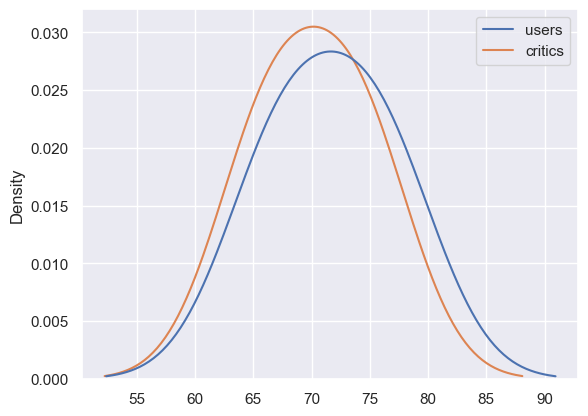

In [10]:
sns.kdeplot(df_bp)

Распределения очевидно пересекаются, так что да, критики относятся к играм так же, как и обычные юзеры. Прогоним для убедительности через Т-Тест

In [11]:
from scipy.stats import ttest_ind

ttest_ind(df_bp['users'],df_bp['critics'])

Ttest_indResult(statistic=0.26558133944583684, pvalue=0.8154319891878139)

Мы получили ожидаемый результат, как у графика выше. Не можем отвергнуть нулевую гипотезу, о том, что критики относятся к играм так же, как обычные юзеры 

### 2. Критикам нравятся больше игры на PC или на PS4?

Нулевая гипотеза заключается в том, что их отношение к этим играм одинаково </br>
Альтернативная - оценки различаются в зависимости от устройства

In [12]:
df.Platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [13]:
df2 = df.loc[(df.Platform == 'PC') | (df.Platform == 'PS4')][['Name', 'Platform', 'Critic_Score']].dropna().reset_index(drop=True).copy()

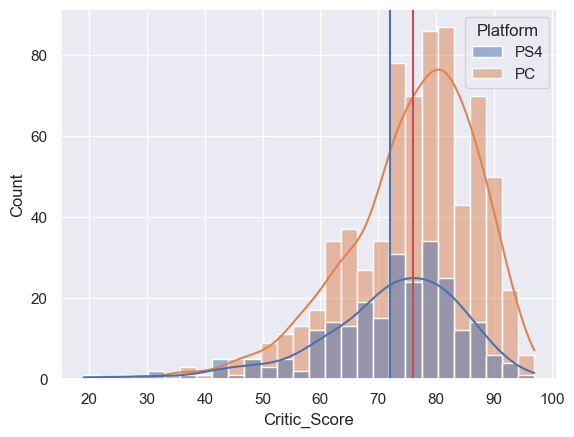

In [14]:
import matplotlib.pyplot as plt

sns.histplot(df2, x='Critic_Score', hue='Platform', kde=True)
plt.axvline(df2[df2.Platform == 'PC']['Critic_Score'].mean(), c='r')
plt.axvline(df2[df2.Platform == 'PS4']['Critic_Score'].mean(), c='b')

Окей, видим некую близость, но нормальным распределение бы не назвал, исходя из того, что их среднее сдвинуто влево. Так что прогоним так же через бутстрап.

In [15]:
bp_ps4 = []
bp_pc = []
for i in range(5000):
    bp_ps4.append(df2[df2.Platform == 'PS4'].sample(50, replace=True)['Critic_Score'].mean())
    bp_pc.append(df2[df2.Platform == 'PC'].sample(50, replace=True)['Critic_Score'].mean())

df_bp = pd.DataFrame()
df_bp['ps4'] = pd.Series(bp_ps4).quantile([0.025, 0.975])
df_bp['pc'] = pd.Series(bp_pc).quantile([0.025, 0.975])

<AxesSubplot: ylabel='Density'>

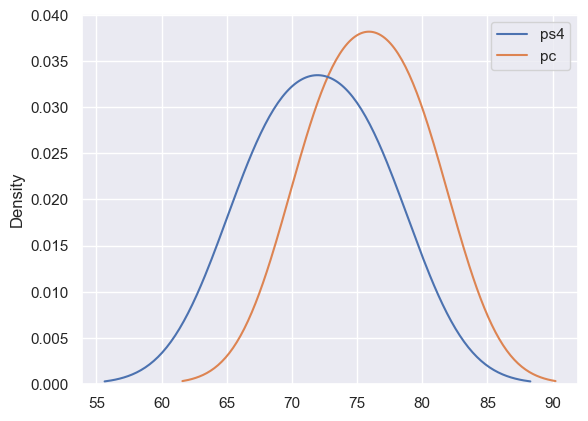

In [16]:
sns.kdeplot(df_bp)

Ситуация та же, они пересекаются, очевидно статистически значимо не отличаются

In [17]:
ttest_ind(df_bp['pc'],df_bp['ps4'])

Ttest_indResult(statistic=0.8536097190008045, pvalue=0.4832440684080235)

Ну чуть больше различие, но не сильно. Не можем отвергнуть нулевую гипотезу

### 3 Критикам больше нравятся стрелялки или стратегии?

Нулевая гипотеза заключается в том, что критикам они нравятся одинаково и оценки статистически значимо не отличаются <br>
Альтернативная в том, что критикам что-то нравится больше

In [18]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df.Genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [20]:
df3 = df.loc[(df.Genre == 'Shooter')| (df.Genre == 'Strategy')][['Name', 'Genre', 'Critic_Score']].dropna().reset_index(drop=True).copy()

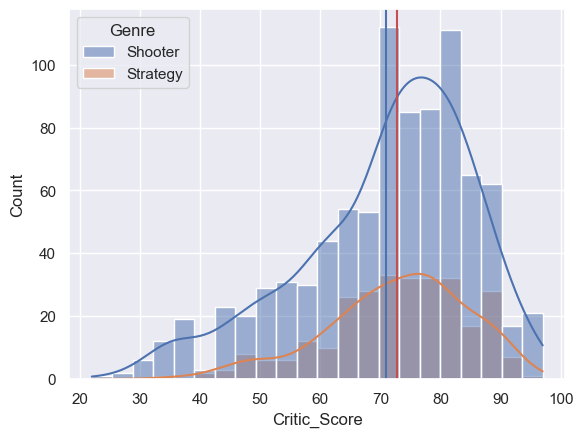

In [21]:
sns.histplot(df3, x='Critic_Score', hue='Genre', kde=True)
plt.axvline(df3[df3.Genre == 'Strategy']['Critic_Score'].mean(), c='r')
plt.axvline(df3[df3.Genre == 'Shooter']['Critic_Score'].mean(), c='b')

Ситуация та же, сделаем все так же

In [22]:
bp_str = []
bp_sht = []
for i in range(5000):
    bp_str.append(df3[df3.Genre == 'Strategy'].sample(50, replace=True)['Critic_Score'].mean())
    bp_sht.append(df3[df3.Genre == 'Shooter'].sample(50, replace=True)['Critic_Score'].mean())

df_bp = pd.DataFrame()
df_bp['shooter'] = pd.Series(bp_sht).quantile([0.025, 0.975])
df_bp['strategy'] = pd.Series(bp_str).quantile([0.025, 0.975])

<AxesSubplot: ylabel='Density'>

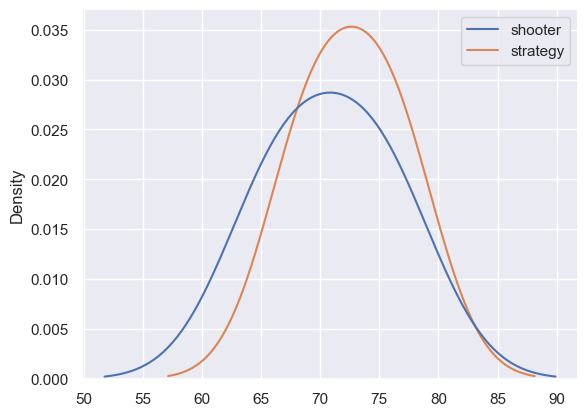

In [23]:
sns.kdeplot(df_bp)

Ситуация не меняется. Статистически значимых различий нет

In [24]:
ttest_ind(df_bp['shooter'],df_bp['strategy'])

Ttest_indResult(statistic=-0.34403810488248043, pvalue=0.7636223363607364)

Что лишний раз доказывает Т-Тест. Не можем отвергнуть нулевую гипотезу

## Задание 2

Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные [здесь](https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/spam.csv)) по признаку спама. Для этого:

1) Привидите весь текст к нижнему регистру;  
2) Удалите мусорные символы;  
3) Удалите стоп-слова;  
4) Привидите все слова к нормальной форме;  
5) Преобразуйте все сообщения в вектора TF-IDF. Вам поможет следующий код:  

```
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.Message)
names = tfidf.get_feature_names_out()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)
```

Можете поэкспериментировать с параметрами [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html);  
6) Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите `random_state=42`. Используйте [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html);  
7) Постройте модель [логистической регрессии](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), укажите `random_state=42`, оцените ее точность на тестовых данных;  
8) Опишите результаты при помощи [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix);  
9) Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

#### ПРИМЕЧАНИЕ
Домашнее задание сдается ссылкой [Google Colab](https://colab.research.google.com/).
Не сможем проверить или помочь, если вы пришлете:
- файлы;
- архивы;
- скриншоты кода.

Все обсуждения и консультации по выполнению домашнего задания ведутся только на соответствующем канале в slack.

##### Как правильно задавать вопросы аспирантам, преподавателям и коллегам?
Прежде чем задать вопрос необходимо попробовать найти ответ самому в интернете. Навык самостоятельного поиска информации – один из важнейших, и каждый практикующий специалист любого уровня это делает каждый день.

Любой вопрос должен быть сформулирован по алгоритму:  
1) Что я делаю?  
2) Какого результата я ожидаю?  
3) Как фактический результат отличается от ожидаемого?  
4) Что я уже попробовал сделать, чтобы исправить проблему?  

По возможности, прикрепляйте к вопросу скриншоты, либо ссылки на код. Оставляйте только проблемный и воспроизводимый участок кода, все решение выкладывать не допускается.
